# ARIMA Modelling: Forecasting Weekly Hotel Cancellations

# Milestone 1

The below defines the procedures for forming the weekly time series as specified.

### Step 1: Import Libraries and define dtypes

In [2]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pmdarima as pm
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf

from numpy.random import seed
seed(1)
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as ts

dtypes = {
        'IsCanceled':                                    'float64',
        'LeadTime':                                          'float64',
        'StaysInWeekendNights':                                     'float64',
        'StaysInWeekNights':                                     'float64',
        'Adults':                            'float64',
        'Children':                            'float64',
        'Babies':                                  'float64',
        'Meal':                                    'category',
        'Country':                                               'category',
        'MarketSegment':                                    'category',
        'DistributionChannel':                                       'category',
        'IsRepeatedGuest':                               'float64',
        'PreviousCancellations':                                    'float64',
        'PreviousBookingsNotCanceled':                          'float64',
        'ReservedRoomType':                                             'category',
        'AssignedRoomType':                                            'category',
        'BookingChanges':                                                'float64',
        'DepositType':                                              'category',
        'Agent':                                              'category',
        'Company':                                 'category',
        'DaysInWaitingList':                                           'float64',
        'CustomerType':                                           'category',
        'ADR':                                          'float64',
        'RequiredCarParkingSpaces':                                      'float64',
        'TotalOfSpecialRequests':                                              'float64',
        'ReservationStatus':                                                'category'
        }

### Step 2: Data is sorted by year and week number

In [3]:
import pandas as pd

df = pd.read_csv("/Users/dmr/Projects/bayes-modeling/#1 arima/H1.csv",
                       dtype=dtypes, converters={'ArrivalDateWeekNumber': '{:0>2}'.format})
df = df.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0.0,342.0,2015,July,27,1,0.0,0.0,2.0,0.0,...,No Deposit,NULL,NULL,0.0,Transient,0.0,0.0,0.0,Check-Out,2015-07-01
1,0.0,737.0,2015,July,27,1,0.0,0.0,2.0,0.0,...,No Deposit,NULL,NULL,0.0,Transient,0.0,0.0,0.0,Check-Out,2015-07-01
2,0.0,7.0,2015,July,27,1,0.0,1.0,1.0,0.0,...,No Deposit,NULL,NULL,0.0,Transient,75.0,0.0,0.0,Check-Out,2015-07-02
3,0.0,13.0,2015,July,27,1,0.0,1.0,1.0,0.0,...,No Deposit,304,NULL,0.0,Transient,75.0,0.0,0.0,Check-Out,2015-07-02
4,0.0,14.0,2015,July,27,1,0.0,2.0,2.0,0.0,...,No Deposit,240,NULL,0.0,Transient,98.0,0.0,1.0,Check-Out,2015-07-03


### Step 3: Year and month are joined together (concatenated)

Use pandas manipulation procedures in order to join the year and month as the timestamp. The below guide offers a detailed explanation of how to concatenate values.

[Data to Fish: How to Concatenate Column Values in Pandas DataFrame](https://datatofish.com/concatenate-values-python/)

In [4]:
df1 = df['ArrivalDateYear'].map(str) + df['ArrivalDateWeekNumber'].map(str)

### Step 4: Cancellation entries are joined with the associated date

In [5]:
df2 = df['IsCanceled']
df3 = pd.concat([df1, df2], axis = 1)
df3.columns = ['FullDate', 'IsCanceled']
df3.sort_values(['FullDate', 'IsCanceled'], ascending=True)

,FullDate,IsCanceled
0,201527,0.0
1,201527,0.0
2,201527,0.0
3,201527,0.0
4,201527,0.0
...,...,...
13799,201735,1.0
13800,201735,1.0
13801,201735,1.0
13802,201735,1.0


### Step 5: Cancellations are aggregated on a weekly basis

In [6]:
df = df3.groupby('FullDate').agg(sum)
df.sort_values(['FullDate'], ascending=True)
df.head()

,IsCanceled
FullDate,
201527,41.0
201528,48.0
201529,87.0
201530,74.0
201531,101.0


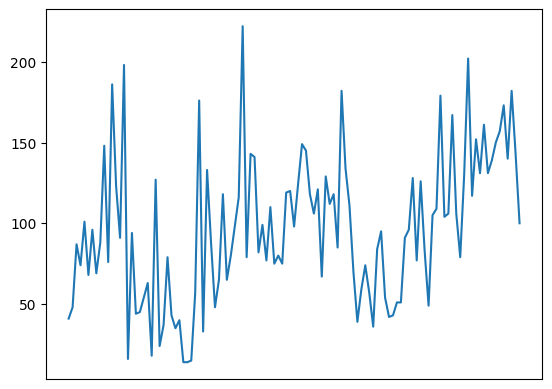

In [7]:
plt.plot(df)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.show()

Note the components of each time series when generating the graph. This provides important visual signals for the structure of the time series, and is important for a more intuitive understanding of the eventual ARIMA model structure that will be chosen.

### Step 6: Time Series Decomposition

In [8]:
decomposition = seasonal_decompose(df, period=52)
residual = decomposition.resid
trend = decomposition.trend
seasonal = decomposition.seasonal

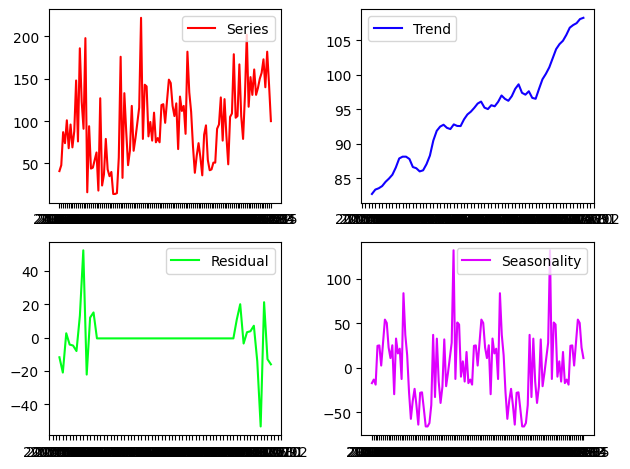

In [9]:
plt.subplot(221)
plt.plot(df,color='#ff0000', label='Series')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend,color='#1100ff', label='Trend')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(223)
plt.plot(residual,color='#00ff1a', label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(224)
plt.plot(seasonal,color='#de00ff', label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Step 7: Autocorrelation and Partial Autocorrelation Plots

In the autocorrelation plot below, the strongest correlation after the period of negatively correlated lags occurs at t=51. In this regard, **m=51** is chosen as the seasonal parameter in the ARIMA model.

This resource provides some useful information in explaining how the seasonality cycle is determined using the autocorrelation function: [Oracle Crystal Ball Predictor User's Guide: Identifying Seasonality with Autocorrelations](https://docs.oracle.com/cd/E57185_01/CBPUG/PRHistData_Autocorr.htm)

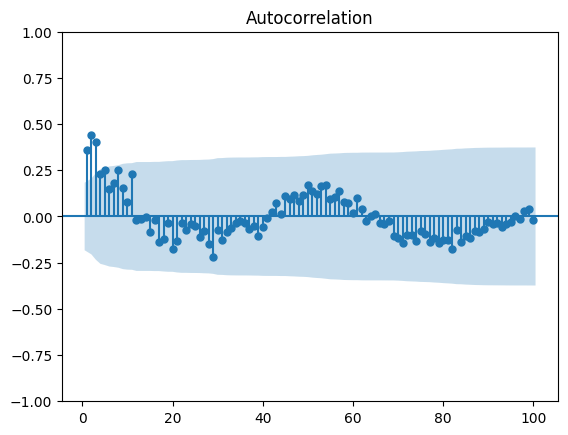

In [10]:
plot_acf(df.IsCanceled, lags=100, zero=False);

/Users/dmr/miniforge3/envs/bayes-modeling/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


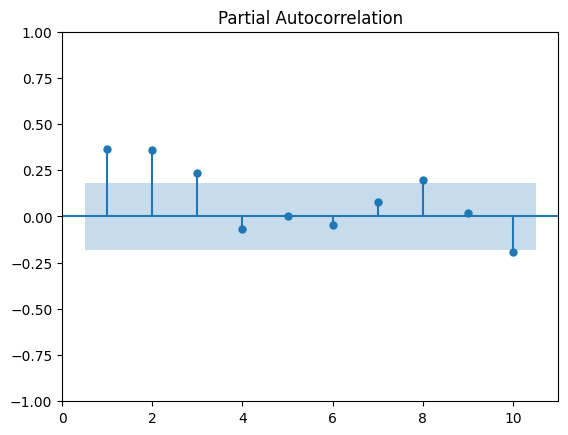

In [11]:
plot_pacf(df.IsCanceled, lags=10, zero=False);

### Step 8: Moving Average

In [12]:
window_size = 4
windows = df['IsCanceled'].rolling(window_size)
moving_averages = windows.mean()
ma = moving_averages[window_size - 1:]
ma = np.array(ma)
print(ma)

[ 62.5   77.5   82.5   84.75  83.5   80.25 100.25  95.25 124.5  133.25
 119.   149.5  107.    99.75  88.    49.75  59.25  51.5   45.    65.5
  58.    51.5   66.75  45.75  48.5   49.25  33.    25.75  20.75  25.
  65.5   70.25  99.75 107.5   75.5   83.5   79.75  74.    82.    90.25
  89.75 129.   128.75 140.   146.25 111.25 116.25  99.75  92.    90.25
  85.5   85.    87.25  98.5  103.   115.25 122.75 129.   134.   129.5
 122.5  103.   105.75 107.25 106.5  111.   124.25 129.75 128.   124.25
  88.5   69.75  60.5   57.25  56.5   62.75  68.    67.25  68.75  58.5
  47.5   46.75  59.    72.25  91.5   98.   106.75 103.5   83.75  90.75
  86.5  110.5  124.25 124.5  139.   120.75 114.5  120.5  129.25 132.
 150.25 150.5  140.25 143.75 140.5  145.25 144.25 154.75 155.   163.
 159.5  141.25]


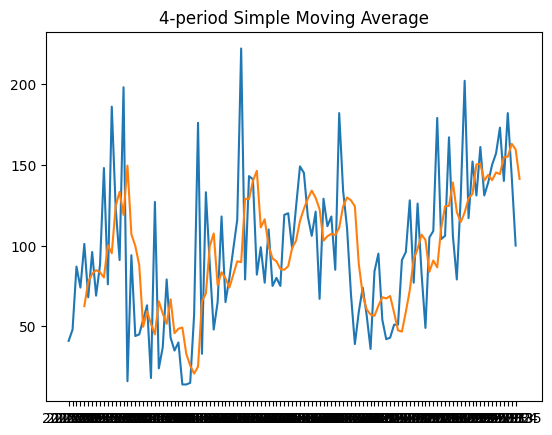

In [13]:
ma_df = np.concatenate([np.array([math.nan, math.nan, math.nan, math.nan]), ma])

plt.plot(df)
plt.plot(ma_df)
plt.title("4-period Simple Moving Average")
plt.show()

### Step 9: Train-Test Split

In [14]:
df_target = df['IsCanceled']
print(df)
df_series = pd.Series(df_target)
train, test = df_series[1:103], df_series[104:115]
print(train.shape)
print(test.shape)

          IsCanceled
FullDate            
201527          41.0
201528          48.0
201529          87.0
201530          74.0
201531         101.0
...              ...
201731         173.0
201732         140.0
201733         182.0
201734         143.0
201735         100.0

[115 rows x 1 columns]
(102,)
(11,)


In [15]:
test

FullDate
201725    131.0
201726    161.0
201727    131.0
201728    139.0
201729    150.0
201730    157.0
201731    173.0
201732    140.0
201733    182.0
201734    143.0
201735    100.0
Name: IsCanceled, dtype: float64

### Step 10: auto_arima

**pmdarima** is used to automatically generate the coordinates for the ARIMA model based on which model shows the lowest BIC (Bayesian Information Criterion). Please refer to these two references for more information on the installation and configuration of the ARIMA model under this package.

[GitHub Repository: alkaline-ml/pmdarima](https://github.com/alkaline-ml/pmdarima)

[pypi.org: pmdarima](https://pypi.org/project/pmdarima/)

Looking at the autocorrelation function, the correlation drops off after 51 lags.

In this regard, the seasonal factor (m) is set to **51** in the ARIMA configuration.

In [16]:
arima_model = pm.auto_arima(train, start_p=0, start_q=0, max_p=10, max_q=10, start_P=0, start_Q=0, max_P=10, max_Q=10, m=51, stepwise=True, seasonal=True, information_criterion='bic', trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,1,0)[51]             : BIC=578.579, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[51]             : BIC=568.064, Time=2.64 sec
 ARIMA(0,1,1)(0,1,1)[51]             : BIC=inf, Time=4.57 sec
 ARIMA(1,1,0)(0,1,0)[51]             : BIC=564.152, Time=0.27 sec
 ARIMA(1,1,0)(0,1,1)[51]             : BIC=568.064, Time=2.62 sec
 ARIMA(1,1,0)(1,1,1)[51]             : BIC=571.976, Time=2.74 sec
 ARIMA(2,1,0)(0,1,0)[51]             : BIC=561.339, Time=0.53 sec
 ARIMA(2,1,0)(1,1,0)[51]             : BIC=inf, Time=8.93 sec
 ARIMA(2,1,0)(0,1,1)[51]             : BIC=inf, Time=7.39 sec
 ARIMA(2,1,0)(1,1,1)[51]             : BIC=inf, Time=10.24 sec
 ARIMA(3,1,0)(0,1,0)[51]             : BIC=565.160, Time=0.55 sec
 ARIMA(2,1,1)(0,1,0)[51]             : BIC=inf, Time=1.02 sec
 ARIMA(1,1,1)(0,1,0)[51]             : BIC=inf, Time=0.50 sec
 ARIMA(3,1,1)(0,1,0)[51]             : BIC=inf, Time=0.82 sec
 ARIMA(2,1,0)(0,1,0)[51] intercept   : BIC=565.202, Time=0.4

In [17]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  102
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 51)   Log Likelihood                -274.801
Date:                            Sat, 26 Nov 2022   AIC                            555.603
Time:                                    14:38:16   BIC                            561.339
Sample:                                         0   HQIC                           557.787
                                            - 102                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7571      0.169     -4.474      0.000      -1.089      -0.425
ar.L2         -0.3576      0.170     -2.098      0.036      -0.692      -0.024
sigma2      3433.5023    599.108      5.731      0.000    2259.273    4607.732
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 4.55
Prob(Q):                              0.84   Prob(JB):                         0.10
Heteroskedasticity (H):               1.43   Skew:                            -0.58
Prob(H) (two-sided):                  0.47   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
test.index

Index(['201725', '201726', '201727', '201728', '201729', '201730', '201731',
       '201732', '201733', '201734', '201735'],
      dtype='object', name='FullDate')

In [19]:
preds = arima_model.predict(n_periods=11)
preds_df = pd.DataFrame(preds,
                       columns=['Predicted_Cancellations'])
preds_df.index = test.index
preds_df

/Users/dmr/miniforge3/envs/bayes-modeling/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Predicted_Cancellations
FullDate,
201725,137.728373
201726,142.730112
201727,117.800906
201728,176.889361
201729,173.591858
201730,149.450168
201731,178.608457
201732,201.983055
201733,198.084330


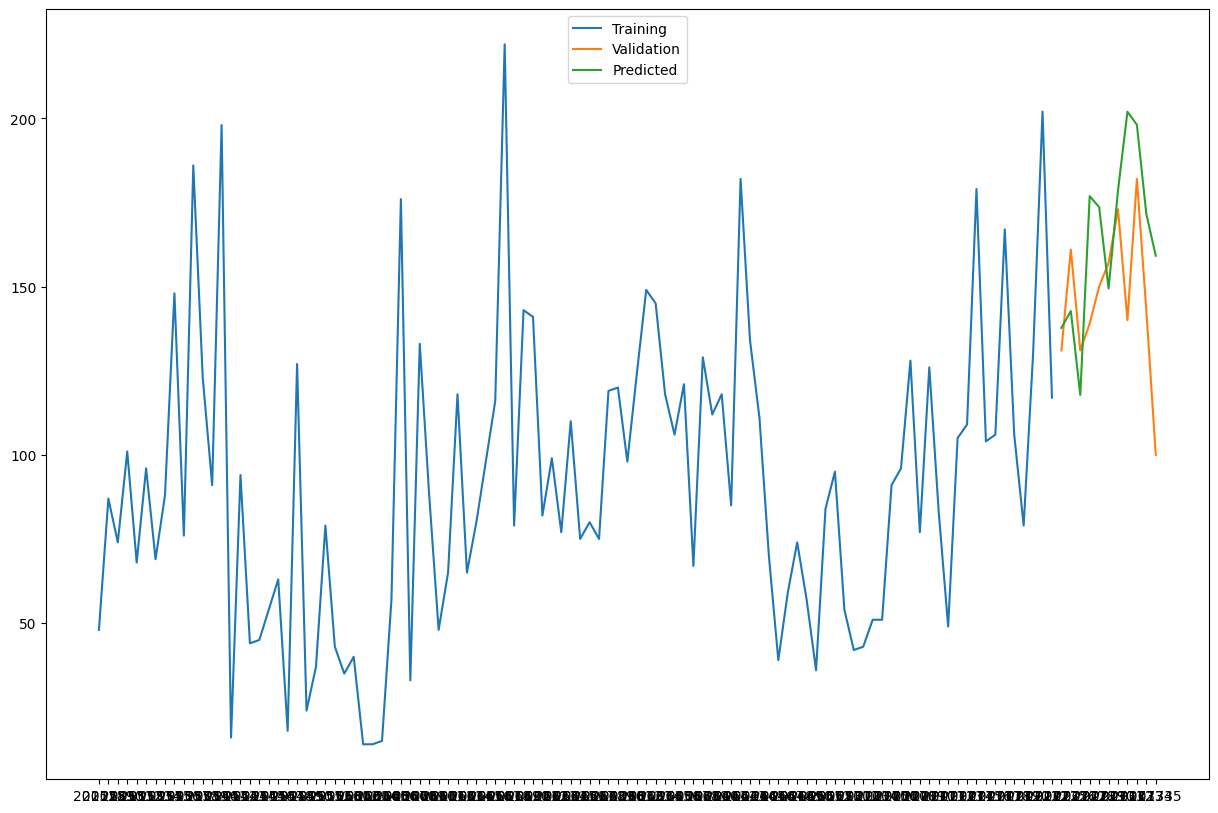

In [20]:
plt.figure(figsize=(15,10))
plt.plot(train, label='Training')
plt.plot(test, label='Validation')
plt.plot(preds_df, label='Predicted')
plt.legend(loc = 'upper center')
plt.show()

### Step 11: Calculate Test RMSE

Note the size of the RMSE relative to the mean value across the test set.

In [21]:
mse = mean_squared_error(test, preds)
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 31.698875


In [22]:
np.mean(test)

146.0909090909091

### Step 12: Interpretation

The most suitable ARIMA model under this circumstance was identified as ARIMA(2,1,0)(0,1,0)[51], with a BIC of 561.339.
The RMSE of 31 is 21% the size of the mean weekly cancellations of 146 for the test set. While a lower RMSE would be preferable, too low an RMSE value would potentially indicate that the model has been “over-trained” on the training set and will do well in forecasting the test set in question, but may perform poorly when it comes to forecasting subsequent data. Therefore, while RMSE is important, it is not regarded as the “be all and end all” when it comes to making accurate forecasts.
Given that a visual scan of the predictions indicate that the model is capturing the shift in trends across different periods, this is an indication that the model is working well for these purposes.